In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import os

2025-06-20 15:37:53.301317: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 15:37:55.449321: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 15:37:56.638940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750430277.855978   87321 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750430278.465113   87321 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750430281.501908   87321 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
file_dict = {
    'Background': '/tmp/all_data/background_for_training.h5',
    'Ato4l': '/tmp/all_data/Ato4l_lepFilter_13TeV_filtered.h5',
    'hChToTauNu': '/tmp/all_data/hChToTauNu_13TeV_PU20_filtered.h5',
    'hToTauTau' : '/tmp/all_data/hToTauTau_13TeV_PU20_filtered.h5', 
    'leptoquark': '/tmp/all_data/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
}

background_file = "/tmp/all_data/background_for_training.h5" # background data file

signal_files = [ # signal data files
    
    '/tmp/all_data/Ato4l_lepFilter_13TeV_filtered.h5',
    '/tmp/all_data/hChToTauNu_13TeV_PU20_filtered.h5',
    '/tmp/all_data/hToTauTau_13TeV_PU20_filtered.h5', 
    '/tmp/all_data/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
]

output_names = [ # names for output files
    "Ato4l_lepFilter",
    "hChToTauNu",
    "hToTauTau",
    "leptoquark_LOWMASS"
]

# creating output folders 
output_folder = '/tmp/all_data/combined_datasets/'
model_output = "/tmp/all_data/models/"

os.makedirs(model_output, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

In [3]:
with h5py.File(file_dict['Ato4l'], 'r') as f:
    particles = f['Particles'][:]
    classes = f['Particles_Classes'][:]
    names = f['Particles_Names'][:]
    event_ids = f.get('EvtId')

print(f'particles shape: {particles.shape}')
print(f'classes shape: {classes.shape}')
print(f'names shape: {names.shape}')
print(f'event_ids shape: {event_ids.shape if event_ids is not None else "No event_ids found"}')

particles shape: (55969, 19, 4)
classes shape: (4,)
names shape: (4,)
event_ids shape: No event_ids found


In [4]:
print('particles')
print(particles)
print('classes')
print(classes)
print('names')
print(names)
print(event_ids)

particles
[[[ 9.23502350e+00  0.00000000e+00 -1.88284254e+00  1.00000000e+00]
  [ 2.70772038e+01  2.10681868e+00 -2.32072282e+00  2.00000000e+00]
  [ 2.27008305e+01  2.02266026e+00  3.09363747e+00  2.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 2.26857662e+01  0.00000000e+00  1.47127521e+00  1.00000000e+00]
  [ 2.84564648e+01 -1.08470809e+00 -3.89027774e-01  2.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 6.76132965e+00  0.00000000e+00  1.15189862e+00  1.00000000e+00]
  [ 2.80287857e+01  8.48856047e-02 -1.33467388e+00  2.00000000e+00]
  [ 0.00000000e+00  0.

In [5]:
for name, file_path in file_dict.items():
    with h5py.File(file_dict[name], 'r') as f:
        particles = f['Particles'][:]
        classes = f['Particles_Classes'][:]
        names = f['Particles_Names'][:]
        event_ids = f.get('EvtId')

    print(f'Processing {name} from {file_path}')
    print(f'particles shape: {particles.shape}')
    print(f'classes shape: {classes.shape}')
    print(f'names shape: {names.shape}')
    print(f'event_ids shape: {event_ids.shape if event_ids is not None else "No event_ids found"}')

Processing Background from /tmp/all_data/background_for_training.h5
particles shape: (13451915, 19, 4)
classes shape: (4,)
names shape: (4,)
event_ids shape: No event_ids found
Processing Ato4l from /tmp/all_data/Ato4l_lepFilter_13TeV_filtered.h5
particles shape: (55969, 19, 4)
classes shape: (4,)
names shape: (4,)
event_ids shape: No event_ids found
Processing hChToTauNu from /tmp/all_data/hChToTauNu_13TeV_PU20_filtered.h5
particles shape: (760272, 19, 4)
classes shape: (368,)
names shape: (368,)
event_ids shape: No event_ids found
Processing hToTauTau from /tmp/all_data/hToTauTau_13TeV_PU20_filtered.h5
particles shape: (691283, 19, 4)
classes shape: (388,)
names shape: (388,)
event_ids shape: No event_ids found
Processing leptoquark from /tmp/all_data/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
particles shape: (340544, 19, 4)
classes shape: (4,)
names shape: (4,)
event_ids shape: No event_ids found


In [6]:
all_features = []

for name, filepath in file_dict.items():
    with h5py.File(file_dict[name], 'r') as f:
        particles = f['Particles'][:, :, :-1] 
        particles = particles.reshape(particles.shape[0], -1)
    all_features.append(particles)

# combine all datasets into one array
combined_features = np.vstack(all_features)

# fit scaler to all combined data 
scaler = StandardScaler() # saved as scaler, can now call this later 
scaler.fit(combined_features)

,copy,True
,with_mean,True
,with_std,True


In [7]:
def create_supervised_dataset(bkg_file, signal_file, scaler, output_path, events = None, test_size=0.2, val_size=0.2, input_shape=57, random_num=42):
    # load and process background file 
    with h5py.File(bkg_file, 'r') as file:
        bkg_data = file['Particles'][:, :, :-1] # remove the last feature (label)
        np.random.shuffle(bkg_data) # shuffle data to remove bias and ensure randomness
        if events: # if events not None 
            bkg_data = bkg_data[:events, :, :]
        bkg_data_flattened = bkg_data.reshape(bkg_data.shape[0], input_shape)
        y_bkg = np.zeros(bkg_data.shape[0]) #0's for background events

    # load and process signal file
    with h5py.File(signal_file, 'r') as file:
        sig_data = file['Particles'][:, :, :-1] #drop last feature
        if events: # if events not None
            sig_data = sig_data[:events, :, :] 
        sig_data_flattened = sig_data.reshape(sig_data.shape[0], input_shape)
        y_sig = np.ones(sig_data.shape[0]) # 1's for signal events 

        # Subsample background to match signal size
        n_signal = sig_data.shape[0]
        if bkg_data.shape[0] > n_signal:
            indices = np.random.choice(bkg_data.shape[0], size=n_signal, replace=False)
            bkg_data_balanced = bkg_data[indices]
            bkg_data_flat_balanced = bkg_data_flattened[indices]
            y_bkg_balanced = y_bkg[indices]
        else:
            bkg_data_balanced = bkg_data
            bkg_data_flat_balanced = bkg_data_flattened
            y_bkg_balanced = y_bkg

    # Combine balanced datasets
    #X = np.vstack((bkg_data_balanced, sig_data))  # shape: (n_events, 19, 3)
    X_flattened = np.vstack((bkg_data_flat_balanced, sig_data_flattened))  # shape: (n_events, 57)
    y = np.concatenate((y_bkg_balanced, y_sig))

    # Normalise using provided global scaler
    X_flat_scaled = scaler.transform(X_flattened)

    # Train/val/test splitting
    X_train, X_test, y_train, y_test = train_test_split(X_flat_scaled, y, test_size=test_size, stratify=y, random_state=random_num)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=random_num)

    with h5py.File(output_path, 'w') as h5f:
        h5f.create_dataset('X_train', data=X_train)
        h5f.create_dataset('y_train', data=y_train)
        h5f.create_dataset('X_val', data=X_val)
        h5f.create_dataset('y_val', data=y_val)
        h5f.create_dataset('X_test', data=X_test)
        h5f.create_dataset('y_test', data=y_test)
        #h5f.create_dataset('X', data=X) # save the raw data (shape: (n_events, 19, 3)) for plotting combined distributions 

In [8]:
# create the combined datasets for each signal file 
for signal_file, output_name in zip(signal_files, output_names):
    output_path = f"{output_folder}/{output_name}_dataset.h5"
    create_supervised_dataset(background_file, signal_file, scaler, output_path, events= None, test_size=0.2, val_size=0.2, input_shape=57, random_num=42)

In [9]:
# create supervised binary classifier NN 
def build_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

2025-06-20 15:47:49.473501: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7729 - loss: 0.4878 - val_accuracy: 0.8466 - val_loss: 0.3683
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8508 - loss: 0.3664 - val_accuracy: 0.8603 - val_loss: 0.3427
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8636 - loss: 0.3413 - val_accuracy: 0.8694 - val_loss: 0.3259
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8704 - loss: 0.3282 - val_accuracy: 0.8747 - val_loss: 0.3159
Epoch 5/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8737 - loss: 0.3214 - val_accuracy: 0.8770 - val_loss: 0.3092
Epoch 6/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8788 - loss: 0.3120 - val_accuracy: 0.8806 - val_loss: 0.3028
Epoch 7/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8785 - loss: 0.3080 - val_accuracy: 0.8824 - val_loss: 0.2978
Epoch 8/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8815 - loss: 0.3038 - val_accuracy: 0.

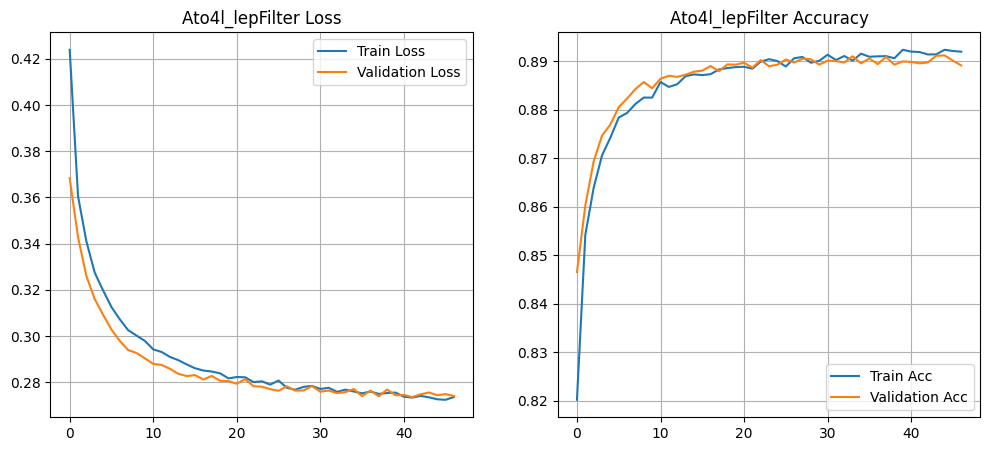

Epoch 1/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8689 - loss: 0.3301 - val_accuracy: 0.8859 - val_loss: 0.2867
Epoch 2/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8843 - loss: 0.2905 - val_accuracy: 0.8873 - val_loss: 0.2830
Epoch 3/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8849 - loss: 0.2877 - val_accuracy: 0.8882 - val_loss: 0.2810
Epoch 4/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8858 - loss: 0.2861 - val_accuracy: 0.8877 - val_loss: 0.2800
Epoch 5/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8861 - loss: 0.2852 - val_accuracy: 0.8887 - val_loss: 0.2798
Epoch 6/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8863 - loss: 0.2851 - val_accuracy: 0.8887 - val_loss: 0.2786
Epoch 7/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8866 - loss: 0.2844 - val_accuracy: 0.8888 - val_loss: 0.2783
Epoch 8/50
7603/7603 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8865 - loss: 0

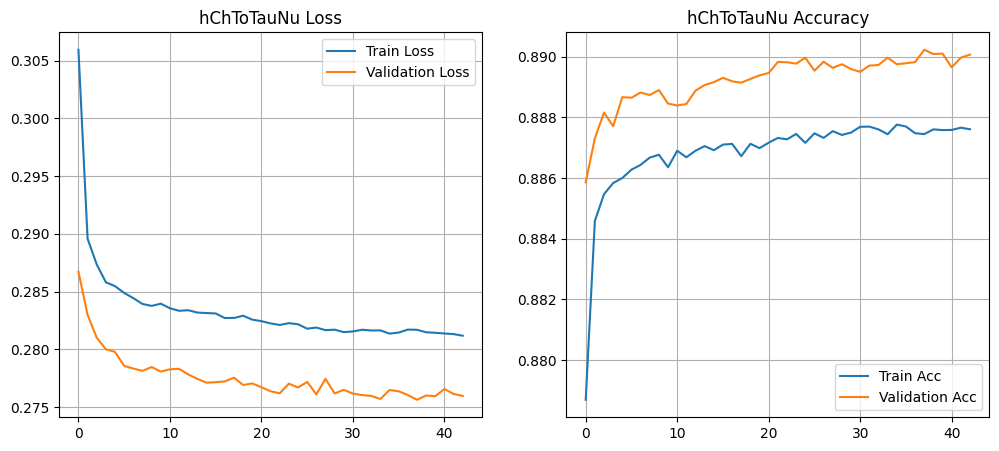

Epoch 1/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6972 - loss: 0.5685 - val_accuracy: 0.7335 - val_loss: 0.5215
Epoch 2/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7306 - loss: 0.5250 - val_accuracy: 0.7403 - val_loss: 0.5120
Epoch 3/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7344 - loss: 0.5185 - val_accuracy: 0.7431 - val_loss: 0.5076
Epoch 4/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7372 - loss: 0.5146 - val_accuracy: 0.7456 - val_loss: 0.5049
Epoch 5/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7375 - loss: 0.5136 - val_accuracy: 0.7460 - val_loss: 0.5026
Epoch 6/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7389 - loss: 0.5125 - val_accuracy: 0.7475 - val_loss: 0.5022
Epoch 7/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7398 - loss: 0.5102 - val_accuracy: 0.7478 - val_loss: 0.5004
Epoch 8/50
6913/6913 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7415 - loss: 0

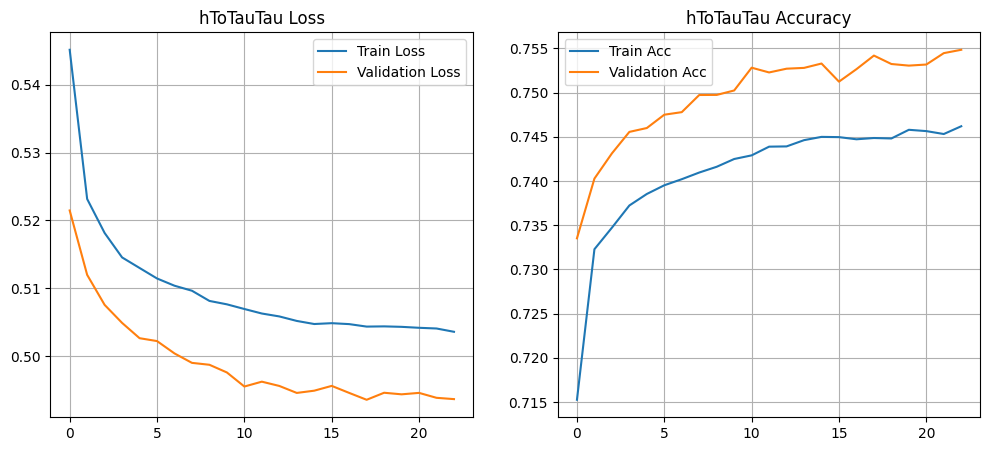

Epoch 1/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7883 - loss: 0.4651 - val_accuracy: 0.8254 - val_loss: 0.3924
Epoch 2/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8229 - loss: 0.3993 - val_accuracy: 0.8285 - val_loss: 0.3849
Epoch 3/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8261 - loss: 0.3911 - val_accuracy: 0.8297 - val_loss: 0.3807
Epoch 4/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8275 - loss: 0.3880 - val_accuracy: 0.8315 - val_loss: 0.3783
Epoch 5/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8278 - loss: 0.3848 - val_accuracy: 0.8321 - val_loss: 0.3769
Epoch 6/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8282 - loss: 0.3837 - val_accuracy: 0.8318 - val_loss: 0.3761
Epoch 7/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8288 - loss: 0.3830 - val_accuracy: 0.8329 - val_loss: 0.3756
Epoch 8/50
3406/3406 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8294 - loss: 0.3828 - 

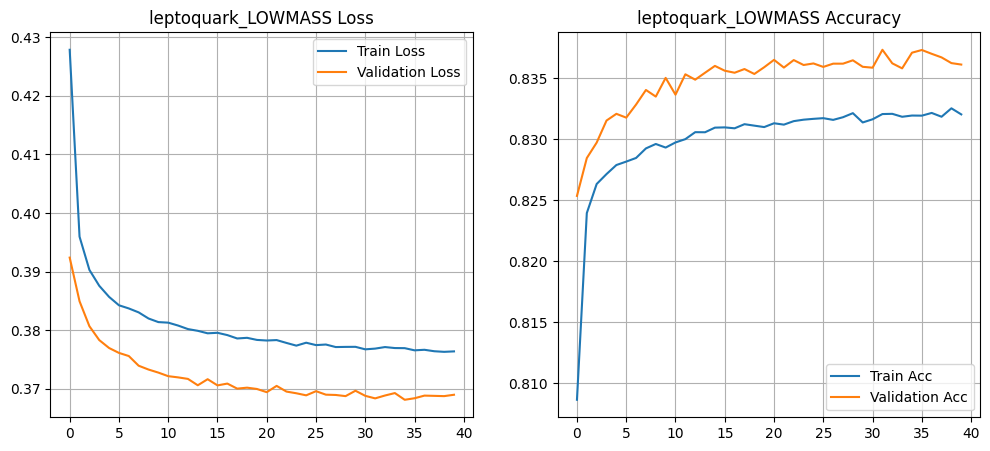

In [10]:
for output_name in output_names:
    file_path = f"{output_folder}/{output_name}_dataset.h5"
    with h5py.File(file_path, 'r') as f:
        X_train = f['X_train'][:]
        y_train = f['y_train'][:]
        X_val = f['X_val'][:]
        y_val = f['y_val'][:]

    model = build_model(input_dim=57)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=128, callbacks=[early_stop])
    
    # Save the model
    model.save(f"{model_output}/{output_name}_model.h5")

    # Plot training
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"{output_name} Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Validation Acc')
    plt.legend()
    plt.title(f"{output_name} Accuracy")
    plt.grid()
    plt.show()

700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


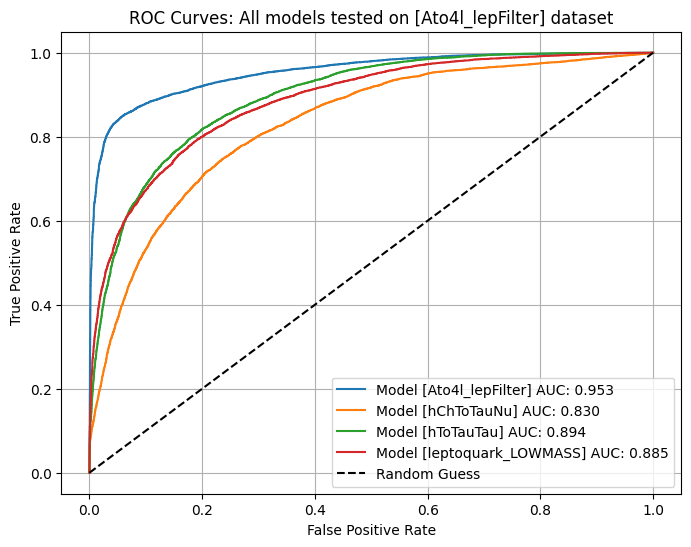

9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 590us/step


9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 581us/step


9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 592us/step


9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 586us/step


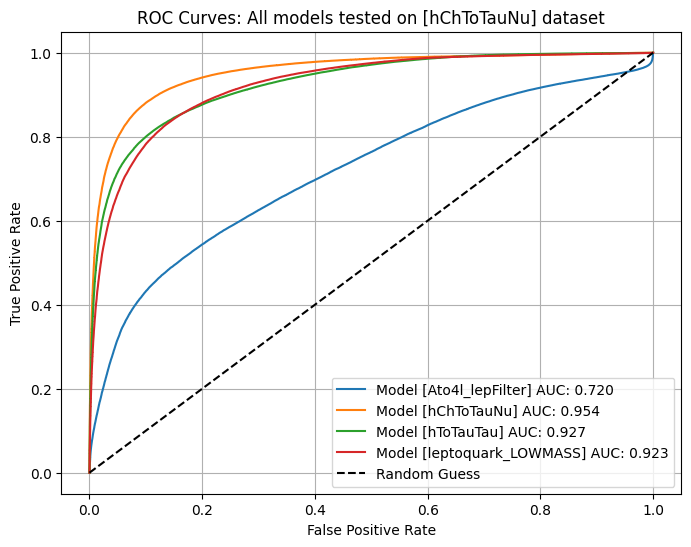

8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 565us/step


8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 576us/step


8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 605us/step


8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 588us/step


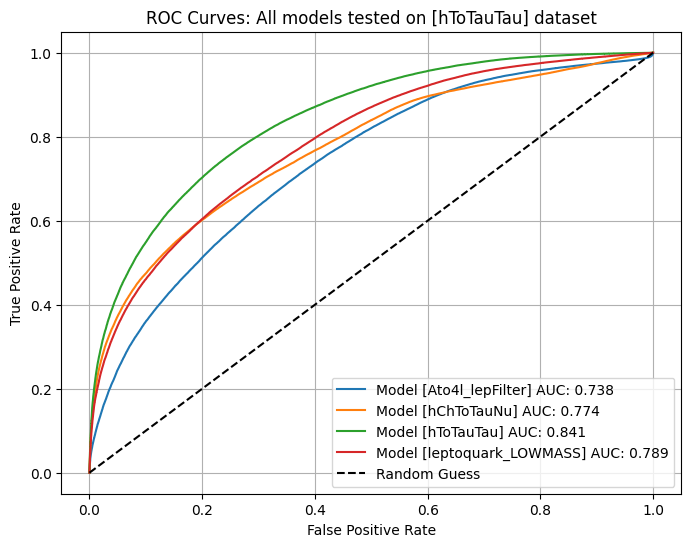

4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 597us/step


4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 579us/step


4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 604us/step


4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 581us/step


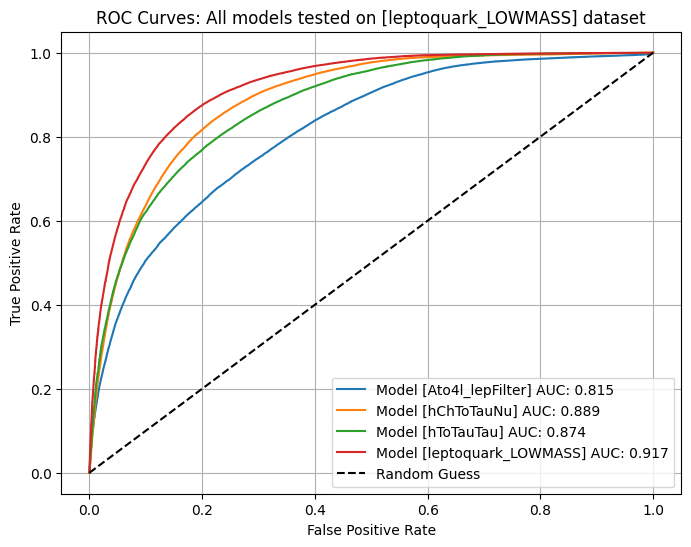

In [11]:
# cross testing models (ROC CURVES)

for test_name in output_names:
    with h5py.File(f"{output_folder}/{test_name}_dataset.h5", 'r') as f:
        X_test = f['X_test'][:]
        y_test = f['y_test'][:]

    plt.figure(figsize=(8,6))
    
    for train_name in output_names:
        model = load_model(f"{model_output}/{train_name}_model.h5")
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"Model [{train_name}] AUC: {auc:.3f}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves: All models tested on [{test_name}] dataset")
    plt.legend()
    plt.grid()
    plt.show()


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 588us/step
8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 582us/step
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 2s 583us/step


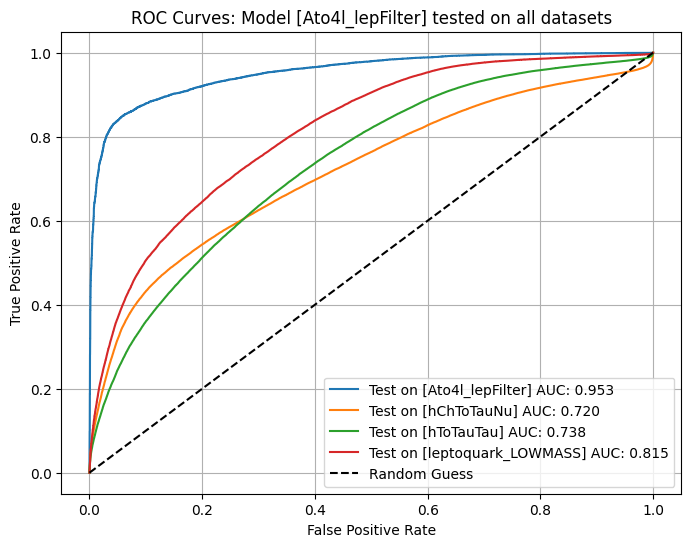

700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 593us/step
8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 594us/step
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 595us/step


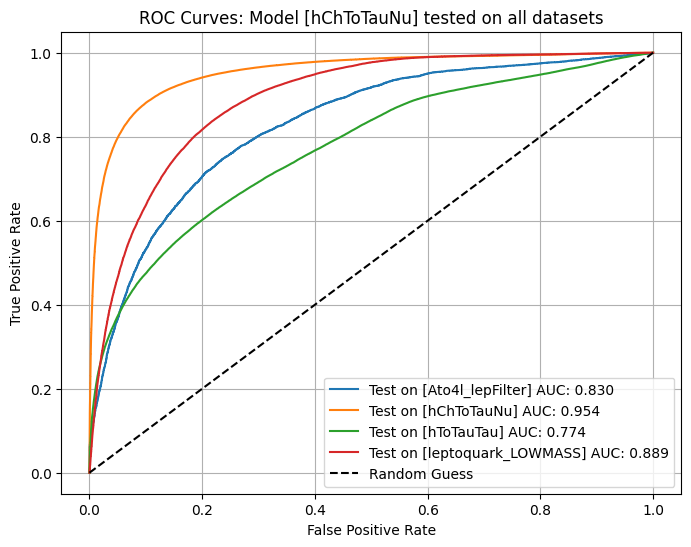

700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step
9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 605us/step
8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 603us/step
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 596us/step


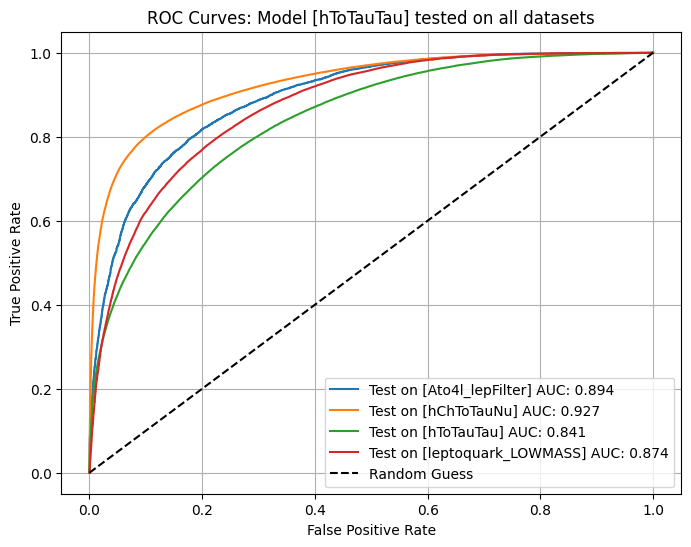

700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step
9504/9504 ━━━━━━━━━━━━━━━━━━━━ 6s 598us/step
8642/8642 ━━━━━━━━━━━━━━━━━━━━ 5s 601us/step
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step


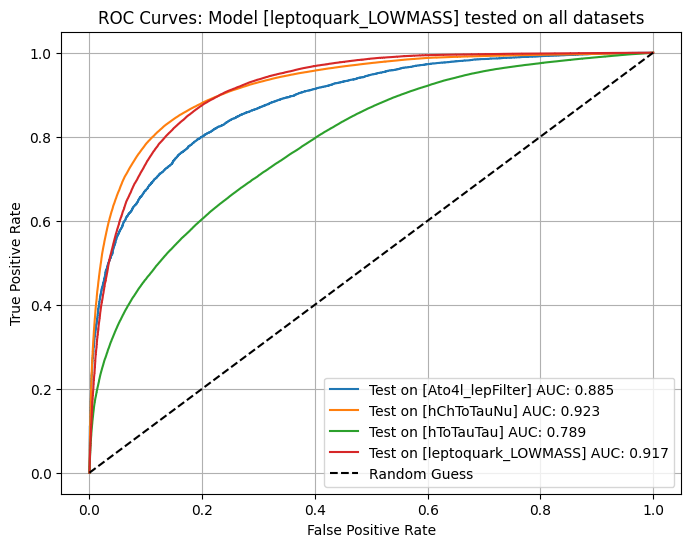

In [12]:
for train_name in output_names:
    model = load_model(f"{model_output}/{train_name}_model.h5")
    plt.figure(figsize=(8, 6))

    for test_name in output_names:
        with h5py.File(f"{output_folder}/{test_name}_dataset.h5", 'r') as f:
            X_test = f['X_test'][:]
            y_test = f['y_test'][:]

        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"Test on [{test_name}] AUC: {auc:.3f}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves: Model [{train_name}] tested on all datasets")
    plt.legend()
    plt.grid()
    plt.show()